In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import ndes.nde as nde
import distributions.priors as priors
import compression.IMNN.IMNN_delfi as IMNN

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Fiducial power spectrum
C = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, N)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = cosmic_shear.power_spectrum(theta_plus, pz_fid, modes, np.zeros((nz, nz)))
    Cm = cosmic_shear.power_spectrum(theta_minus, pz_fid, modes, np.zeros((nz, nz)))
    C0 = cosmic_shear.power_spectrum(theta_fiducial, pz_fid, modes, np.zeros((nz, nz)))

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = cosmic_shear.fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

In [4]:
# Define the simulator function: takes parameters, spits out simulated data
# Should have the form: simulator(parameters, args) -> simulated dataset
simulator = cosmic_shear.simulate
simulator_args = [pz_fid, modes, N, nl]

In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [230]:
## Define the compression function: takes data, spits out compressed summaries
## Should have the form compressor(data, args) -> compressed summaries
## NB: compression should be set-up like a quasi maximum-likelihood estimator
der_ = np.array([0.001, 0.001, 0.0005, 0.001, 0.001])
der = [theta_fiducial - der_, theta_fiducial + der_]
initial_sims = 1000
n_epochs = 500
       
proposal_sims = 100
F, test_F, n = IMNN.train_IMNN(simulator, simulator_args, theta_fiducial, der, initial_sims, "cosmic_shear", n_epochs, Q, prior, proposal_sims, make_simulations = False)
compressor = IMNN.IMNN_compressor
compressor_args = n

(1000, 1000) (50, 5, 1000) (50, 5, 1000) (1000, 1000) (50, 5, 1000) (50, 5, 1000) (100, 1000)
[1000, 500, 250, 125, 62, 31]
saving model as compression/cosmic_shear.meta
saving the graph as compression/cosmic_shear.meta





  0%|          | 0/500 [00:00<?, ?it/s]

InvalidArgumentError: Input is not invertible.
	 [[Node: inverse_central_covariance = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](central_covariance)]]

Caused by op 'inverse_central_covariance', defined at:
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-230-2246d4b23983>", line 10, in <module>
    F, test_F, n = IMNN.train_IMNN(simulator, simulator_args, theta_fiducial, der, initial_sims, "cosmic_shear", n_epochs, Q, prior, proposal_sims, make_simulations = False)
  File "/Users/charnock/Physics/delfi/compression/IMNN/IMNN_delfi.py", line 91, in train_IMNN
    n.setup(η = η)
  File "compression/IMNN/IMNN.py", line 684, in setup
    F, _, _, _ ,_ = n.Fisher(output_central, output_m, output_p)
  File "compression/IMNN/IMNN.py", line 456, in Fisher
    iC, μ, C = n.inverse_covariance(a)
  File "compression/IMNN/IMNN.py", line 392, in inverse_covariance
    iC = tf.matrix_inverse(C, name = 'inverse_central_covariance')
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1049, in matrix_inverse
    "MatrixInverse", input=input, adjoint=adjoint, name=name)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[Node: inverse_central_covariance = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](central_covariance)]]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
ax.plot(np.arange(1, n_epochs + 1), F, label = r"training $|{\bf F}_{\alpha\beta}|$")
ax.plot(np.arange(1, n_epochs + 1), test_F, label = r"test $|{\bf F}_{\alpha\beta}|$")
ax.legend(frameon = False)
ax.set_yscale('log')
ax.set_xlim([1, n_epochs])
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$|{\bf F}_{\alpha\beta}|$");

In [ ]:
# Data vector
# Simulate some cosmic shear data
data = simulator(theta_fiducial, simulator_args)
compressed_data = compressor(data, compressor_args)
print(compressed_data)

In [9]:
# Create the DELFI MDN object
n_components = 3
mdn = nde.DelfiMixtureDensityNetwork(compressed_data, prior, [lower, upper], np.linalg.inv(n.sess.run(n.test_F)), theta_fiducial, n_components, n_hidden = [50, 50], activations = [tf.nn.tanh, tf.nn.tanh], names = names, labels = labels, ranges = ranges)

Generating pre-training data...
Training on the pre-training data...



Done.
Sampling approximate posterior...
Done.
Saving fish_pretrain_post.pdf


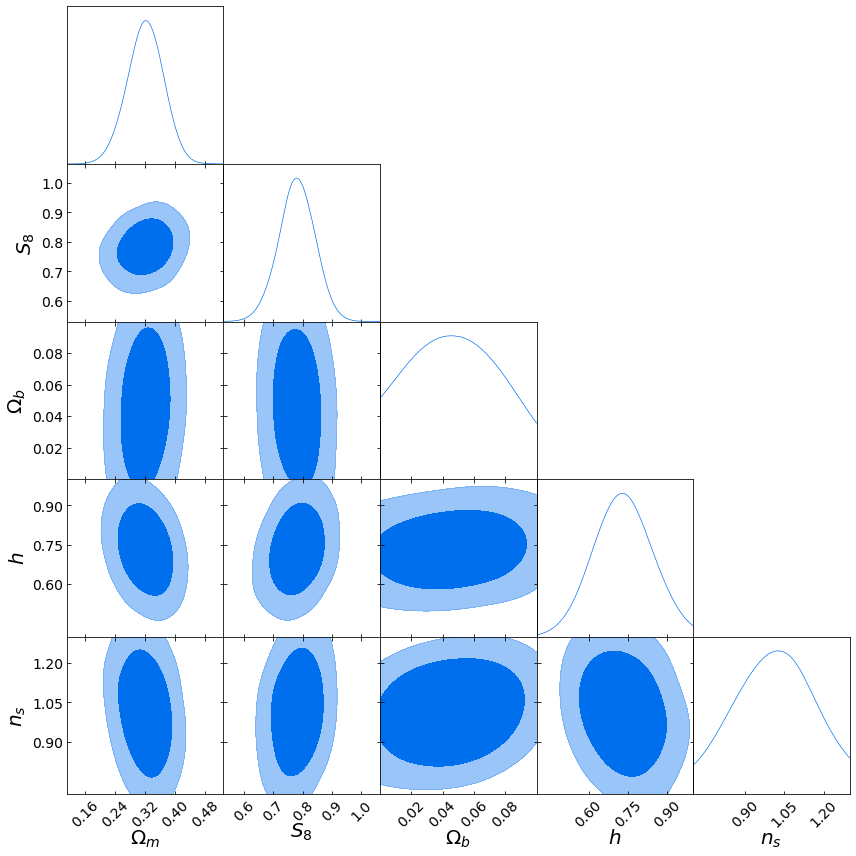

In [10]:
# Do the Fisher pre-training
mdn.sess.run(tf.global_variables_initializer())
mdn.fisher_pretraining(50000, prior, epochs=100, epsilon = 1e-37)

  0%|          | 0/500 [00:00<?, ?it/s]

Running initial 500 sims...
Simulator returns exception for parameter values: [0.13823858 0.42670001 0.09965334 0.46247463 1.24909574] (rank 0)


  2%|▏         | 8/500 [00:04<04:34,  1.79it/s]

Simulator returns exception for parameter values: [0.10280072 0.84895225 0.01943744 0.61055945 0.70432215] (rank 0)
Simulator returns exception for parameter values: [0.11700004 0.89670996 0.01479875 0.59209581 0.80591999] (rank 0)


  2%|▏         | 12/500 [00:07<04:49,  1.68it/s]

Simulator returns exception for parameter values: [0.11179814 0.54074781 0.08192899 0.8067844  0.81149723] (rank 0)
Simulator returns exception for parameter values: [0.04342135 0.72366791 0.02639266 0.61588077 0.9178939 ] (rank 0)


  7%|▋         | 33/500 [00:18<04:19,  1.80it/s]

Simulator returns exception for parameter values: [0.18458838 1.01566532 0.05890207 0.57811908 1.26149657] (rank 0)


  7%|▋         | 37/500 [00:21<04:26,  1.74it/s]

Simulator returns exception for parameter values: [0.27772912 1.10020676 0.03695677 0.77019249 0.99676418] (rank 0)
Simulator returns exception for parameter values: [0.06333596 0.66001377 0.01764049 0.62085449 0.81228247] (rank 0)


  8%|▊         | 39/500 [00:22<04:50,  1.59it/s]/Users/charnock/Physics/delfi/simulators/cosmic_shear/cosmology.py:637: RuntimeWarning: invalid value encountered in double_scalars
  beta_c = 1.0 + b1*(pow(fc, b2) - 1.0)


Simulator returns exception for parameter values: [0.0558035  0.73923771 0.05583538 0.93313441 1.27607163] (rank 0)


  8%|▊         | 41/500 [03:45<5:28:29, 42.94s/it]

Simulator returns exception for parameter values: [0.02022225 0.57294154 0.06865111 0.52827889 1.14045659] (rank 0)


  8%|▊         | 42/500 [15:11<30:00:43, 235.90s/it]

Simulator returns exception for parameter values: [0.35167619 0.41878143 0.06887845 0.58836831 0.7130649 ] (rank 0)


 10%|█         | 52/500 [15:18<54:18,  7.27s/it]    

Simulator returns exception for parameter values: [0.10951731 0.82808954 0.03440556 0.70978314 1.15878405] (rank 0)


 11%|█         | 55/500 [15:20<21:30,  2.90s/it]

Simulator returns exception for parameter values: [0.17695128 1.12412917 0.07255617 0.91705431 1.25693932] (rank 0)


 14%|█▍        | 71/500 [15:35<06:35,  1.08it/s]

Simulator returns exception for parameter values: [0.16260749 0.79993734 0.09156694 0.83703608 0.77740609] (rank 0)
Simulator returns exception for parameter values: [0.0370984  0.62783852 0.04436244 0.99707882 0.98791916] (rank 0)


 15%|█▌        | 77/500 [21:08<2:01:41, 17.26s/it]  

Simulator returns exception for parameter values: [0.05795999 0.99135814 0.06924596 0.99875891 0.73378415] (rank 0)


 17%|█▋        | 85/500 [21:41<18:20,  2.65s/it]  

Simulator returns exception for parameter values: [0.08843091 0.68739704 0.03201541 0.64422905 0.78852106] (rank 0)


 18%|█▊        | 89/500 [21:46<10:45,  1.57s/it]

Simulator returns exception for parameter values: [0.16412105 1.05680066 0.07691212 0.79567217 1.23882093] (rank 0)
Simulator returns exception for parameter values: [0.15184175 0.60490113 0.08540176 0.67349751 0.80924614] (rank 0)


 18%|█▊        | 91/500 [21:48<09:02,  1.33s/it]

Simulator returns exception for parameter values: [0.06179785 0.9558328  0.03997401 0.65302968 0.86628673] (rank 0)
Simulator returns exception for parameter values: [0.13875208 0.96961687 0.08481749 0.51634242 1.14251491] (rank 0)


 23%|██▎       | 114/500 [22:03<06:02,  1.07it/s]

Simulator returns exception for parameter values: [0.25621034 1.10162177 0.01228018 0.98638567 1.07392846] (rank 0)


 23%|██▎       | 115/500 [22:05<07:26,  1.16s/it]

Simulator returns exception for parameter values: [0.19432298 1.17187583 0.00901273 0.72466968 0.77660497] (rank 0)


 24%|██▍       | 119/500 [22:10<07:14,  1.14s/it]

Simulator returns exception for parameter values: [0.0845186  0.60643825 0.00856071 0.54165508 1.21741782] (rank 0)


 24%|██▍       | 121/500 [22:12<07:08,  1.13s/it]

Simulator returns exception for parameter values: [0.09654761 0.66474831 0.02093517 0.57505478 0.88482138] (rank 0)


 28%|██▊       | 141/500 [22:26<03:22,  1.77it/s]

Simulator returns exception for parameter values: [0.12321493 1.0849426  0.07140219 0.66892453 0.91583484] (rank 0)
Simulator returns exception for parameter values: [0.15012433 0.95841276 0.04693997 0.89713442 0.88703284] (rank 0)


 30%|██▉       | 149/500 [22:33<05:46,  1.01it/s]

Simulator returns exception for parameter values: [0.05375296 0.75621005 0.06246421 0.91643052 0.77441997] (rank 0)


 31%|███       | 156/500 [38:56<3:28:28, 36.36s/it]  

Simulator returns exception for parameter values: [0.11252504 0.73485007 0.05367833 0.66220972 1.22039666] (rank 0)


 31%|███▏      | 157/500 [38:59<2:30:28, 26.32s/it]

Simulator returns exception for parameter values: [0.15913206 0.69284458 0.08860439 0.5990824  1.24245241] (rank 0)


 32%|███▏      | 160/500 [39:08<1:01:20, 10.82s/it]

Simulator returns exception for parameter values: [0.08286754 0.7549855  0.0954863  0.83862318 1.18987102] (rank 0)


 32%|███▏      | 162/500 [54:24<18:33:24, 197.65s/it]

Simulator returns exception for parameter values: [0.06714601 0.79483508 0.02542287 0.97741378 0.81899816] (rank 0)


 35%|███▌      | 175/500 [54:32<13:39,  2.52s/it]    

Simulator returns exception for parameter values: [0.05149856 0.95698771 0.05666328 0.98782431 1.01551105] (rank 0)


 35%|███▌      | 176/500 [54:42<26:06,  4.83s/it]

Simulator returns exception for parameter values: [0.213367   0.95563069 0.07939782 0.85538278 0.9437706 ] (rank 0)


 36%|███▌      | 179/500 [54:44<11:17,  2.11s/it]

Simulator returns exception for parameter values: [0.04623742 0.6409665  0.09727718 0.82550162 0.79732195] (rank 0)


 37%|███▋      | 185/500 [55:00<07:22,  1.41s/it]

Simulator returns exception for parameter values: [0.13538441 0.81807591 0.03552144 0.51601917 1.06708925] (rank 0)
Simulator returns exception for parameter values: [0.06746259 0.7681863  0.02290924 0.6087716  1.06677817] (rank 0)


 38%|███▊      | 188/500 [55:02<04:37,  1.12it/s]

Simulator returns exception for parameter values: [0.15145282 0.82783279 0.01063742 0.8516641  1.26683577] (rank 0)


 39%|███▊      | 193/500 [55:05<03:05,  1.65it/s]

Simulator returns exception for parameter values: [0.21142836 1.16474176 0.00406358 0.97969544 1.26302092] (rank 0)


 39%|███▉      | 195/500 [55:06<03:11,  1.59it/s]

Simulator returns exception for parameter values: [0.13858667 0.77093883 0.01563137 0.93353031 0.96001955] (rank 0)


 42%|████▏     | 212/500 [55:15<02:37,  1.83it/s]

Simulator returns exception for parameter values: [0.05075807 0.65381748 0.0522944  0.50567302 1.19224781] (rank 0)
Simulator returns exception for parameter values: [0.07858741 0.76649933 0.02926707 0.90709728 1.28632685] (rank 0)
Simulator returns exception for parameter values: [0.16571758 0.75637516 0.09951036 0.53211227 1.11758999] (rank 0)
Simulator returns exception for parameter values: [0.04354399 0.79181539 0.04415154 0.51337149 1.06172943] (rank 0)


 43%|████▎     | 216/500 [56:16<30:57,  6.54s/it]  

Simulator returns exception for parameter values: [0.01391087 0.53154209 0.04899354 0.83610463 1.04592564] (rank 0)


 46%|████▌     | 229/500 [57:00<05:40,  1.26s/it]  

Simulator returns exception for parameter values: [0.00417027 0.56860736 0.05592624 0.90839305 1.24887002] (rank 0)


 47%|████▋     | 237/500 [57:47<07:06,  1.62s/it]  

Simulator returns exception for parameter values: [0.12051742 1.15437942 0.0221763  0.84050586 0.87438016] (rank 0)


 48%|████▊     | 239/500 [57:48<04:48,  1.10s/it]

Simulator returns exception for parameter values: [0.12849018 0.95334798 0.00735827 0.80846013 1.00275649] (rank 0)


 49%|████▉     | 246/500 [57:52<02:29,  1.70it/s]

Simulator returns exception for parameter values: [0.12553503 0.92406976 0.05227084 0.74030286 0.96603374] (rank 0)


 52%|█████▏    | 258/500 [57:59<02:09,  1.87it/s]

Simulator returns exception for parameter values: [0.15135176 0.74676173 0.08537738 0.71342531 1.140784  ] (rank 0)
Simulator returns exception for parameter values: [0.03636304 0.70416698 0.09222492 0.8617698  1.08430331] (rank 0)


 52%|█████▏    | 262/500 [58:53<24:22,  6.15s/it]  

Simulator returns exception for parameter values: [0.14988988 0.94831443 0.08906014 0.64643712 0.89206806] (rank 0)


 53%|█████▎    | 267/500 [58:58<06:46,  1.74s/it]

Simulator returns exception for parameter values: [0.06502467 0.52572762 0.05681281 0.80823563 1.08638101] (rank 0)


 54%|█████▎    | 268/500 [58:59<05:34,  1.44s/it]

Simulator returns exception for parameter values: [0.24250136 1.1196265  0.01586953 0.57584704 0.74998487] (rank 0)


 54%|█████▍    | 269/500 [59:00<04:43,  1.23s/it]

Simulator returns exception for parameter values: [0.01194908 0.52486213 0.00095562 0.87995159 0.90826953] (rank 0)


 55%|█████▌    | 275/500 [59:03<02:23,  1.57it/s]

Simulator returns exception for parameter values: [0.20041643 0.86668402 0.08002144 0.52899916 1.26296018] (rank 0)
Simulator returns exception for parameter values: [0.19543528 0.83492656 0.06946175 0.9302398  0.96674541] (rank 0)


 56%|█████▌    | 279/500 [59:06<02:08,  1.72it/s]

Simulator returns exception for parameter values: [0.12575933 0.93291887 0.03264357 0.71324254 0.74235931] (rank 0)


 56%|█████▌    | 281/500 [59:07<02:06,  1.73it/s]

Simulator returns exception for parameter values: [0.17550371 0.89504154 0.04923939 0.90640667 0.93798809] (rank 0)


 57%|█████▋    | 284/500 [59:09<02:03,  1.74it/s]

Simulator returns exception for parameter values: [0.12224483 0.66716156 0.09680155 0.7315568  0.94094555] (rank 0)


 57%|█████▋    | 286/500 [59:10<02:05,  1.71it/s]

Simulator returns exception for parameter values: [0.23211266 1.03174913 0.09501928 0.79375387 0.84668965] (rank 0)


 58%|█████▊    | 291/500 [59:13<01:59,  1.75it/s]

Simulator returns exception for parameter values: [0.17144893 0.8513569  0.05791405 0.49761425 1.16029058] (rank 0)


 60%|██████    | 300/500 [59:18<01:53,  1.76it/s]

Simulator returns exception for parameter values: [0.01870566 0.64166169 0.02440761 0.56739236 1.05217849] (rank 0)


 61%|██████    | 304/500 [1:00:52<33:32, 10.27s/it]  

Simulator returns exception for parameter values: [0.03438199 0.85473472 0.07188796 0.99364085 0.70951275] (rank 0)


 61%|██████    | 305/500 [1:01:01<31:20,  9.64s/it]

Simulator returns exception for parameter values: [0.21523603 0.99466449 0.0528195  0.5304559  1.06533345] (rank 0)
Simulator returns exception for parameter values: [0.12304683 0.93467808 0.05357896 0.64217185 1.22458287] (rank 0)


 61%|██████    | 306/500 [1:01:02<22:50,  7.06s/it]

Simulator returns exception for parameter values: [0.12700927 0.81976265 0.093546   0.61196687 1.27977759] (rank 0)
Simulator returns exception for parameter values: [0.00879965 0.49434836 0.04303553 0.67984122 1.1237671 ] (rank 0)


 62%|██████▏   | 312/500 [1:01:22<07:51,  2.51s/it]

Simulator returns exception for parameter values: [0.1878883  1.15018144 0.01863477 0.47014743 0.73787679] (rank 0)


 64%|██████▍   | 320/500 [1:01:32<03:44,  1.25s/it]

Simulator returns exception for parameter values: [0.07526318 1.05452776 0.00939185 0.87994625 1.03408598] (rank 0)


 64%|██████▍   | 321/500 [1:01:33<03:51,  1.29s/it]

Simulator returns exception for parameter values: [0.05381803 1.01152111 0.08513849 0.98810676 0.9508128 ] (rank 0)


 66%|██████▌   | 328/500 [1:04:06<17:54,  6.25s/it]  

Simulator returns exception for parameter values: [0.03862061 0.61795061 0.08204992 0.47431054 0.76975847] (rank 0)


 68%|██████▊   | 341/500 [1:04:45<01:54,  1.39it/s]

Simulator returns exception for parameter values: [0.04355545 0.55910955 0.04701662 0.65530071 1.03314181] (rank 0)
Simulator returns exception for parameter values: [0.12517387 1.07656551 0.00164182 0.7891971  1.12249588] (rank 0)


 69%|██████▉   | 347/500 [1:05:54<09:57,  3.90s/it]

Simulator returns exception for parameter values: [0.17009896 0.80314039 0.08170383 0.65010089 1.18435243] (rank 0)


 70%|███████   | 351/500 [1:05:57<03:23,  1.36s/it]

Simulator returns exception for parameter values: [0.09982597 0.70330085 0.03397835 0.45039771 1.18271699] (rank 0)


 71%|███████   | 356/500 [1:06:00<01:40,  1.44it/s]

Simulator returns exception for parameter values: [0.04616947 0.53089405 0.07273998 0.50460774 1.0569145 ] (rank 0)
Simulator returns exception for parameter values: [0.14624536 0.82630062 0.07941068 0.79700819 1.2616515 ] (rank 0)


 73%|███████▎  | 367/500 [1:09:01<05:40,  2.56s/it]  

Simulator returns exception for parameter values: [0.14744633 0.77597471 0.07020827 0.84909008 0.89256075] (rank 0)


 74%|███████▎  | 368/500 [1:09:03<04:50,  2.20s/it]

Simulator returns exception for parameter values: [0.09693727 0.62674069 0.06478204 0.69092505 0.72419068] (rank 0)


 74%|███████▍  | 369/500 [1:09:04<04:24,  2.02s/it]

Simulator returns exception for parameter values: [0.12358348 0.68461843 0.08271623 0.73322035 1.02964815] (rank 0)


 76%|███████▌  | 378/500 [1:09:11<01:18,  1.55it/s]

Simulator returns exception for parameter values: [0.19477391 1.06825204 0.07664126 0.6584051  0.8374406 ] (rank 0)


 76%|███████▋  | 382/500 [1:09:14<01:10,  1.67it/s]

Simulator returns exception for parameter values: [0.17298961 0.98783673 0.04538797 0.9394564  1.03228203] (rank 0)


 78%|███████▊  | 392/500 [1:09:19<01:00,  1.79it/s]

Simulator returns exception for parameter values: [0.22276759 1.01146959 0.03904734 0.98309971 0.88385411] (rank 0)


 79%|███████▊  | 393/500 [1:09:20<01:08,  1.56it/s]

Simulator returns exception for parameter values: [0.16446611 0.92058476 0.07651093 0.89125339 0.88813538] (rank 0)


 80%|████████  | 402/500 [1:09:25<00:54,  1.78it/s]

Simulator returns exception for parameter values: [0.09234435 0.9382244  0.06904881 0.85911523 1.09070263] (rank 0)


 82%|████████▏ | 409/500 [1:09:29<00:50,  1.80it/s]

Simulator returns exception for parameter values: [0.00767179 0.65195562 0.08676078 0.57938    1.17160846] (rank 0)


 83%|████████▎ | 414/500 [1:09:46<02:36,  1.82s/it]

Simulator returns exception for parameter values: [0.14197995 0.90184598 0.02255372 0.88320642 0.73589953] (rank 0)


 86%|████████▌ | 429/500 [1:09:55<00:39,  1.81it/s]

Simulator returns exception for parameter values: [0.22328834 0.94038647 0.09281614 0.63650857 1.28480049] (rank 0)


 87%|████████▋ | 435/500 [1:09:59<00:34,  1.90it/s]

Simulator returns exception for parameter values: [0.05527994 0.56291041 0.0583433  0.51897484 0.9332988 ] (rank 0)
Simulator returns exception for parameter values: [0.13641605 0.89052049 0.01943244 0.73452794 1.06601624] (rank 0)
Simulator returns exception for parameter values: [0.119603   0.59212944 0.07651528 0.50430134 1.27888726] (rank 0)


 88%|████████▊ | 441/500 [1:10:09<00:52,  1.13it/s]

Simulator returns exception for parameter values: [0.11423174 0.92426099 0.05538259 0.81794198 0.93455328] (rank 0)


 90%|████████▉ | 449/500 [1:10:13<00:30,  1.68it/s]

Simulator returns exception for parameter values: [0.06442249 0.56822991 0.01274621 0.99569447 0.98403465] (rank 0)


 91%|█████████ | 455/500 [1:10:18<00:42,  1.07it/s]

Simulator returns exception for parameter values: [0.03531974 0.40737131 0.00566079 0.92089158 0.93226619] (rank 0)


 92%|█████████▏| 458/500 [1:10:22<00:45,  1.08s/it]

Simulator returns exception for parameter values: [0.02082885 0.60127949 0.08274641 0.5719337  1.1999628 ] (rank 0)


 93%|█████████▎| 465/500 [1:10:39<00:50,  1.46s/it]

Simulator returns exception for parameter values: [0.18377989 1.00860051 0.07504598 0.78410436 1.19221821] (rank 0)
Simulator returns exception for parameter values: [0.10051844 0.97572374 0.00746281 0.92848187 0.98735232] (rank 0)
Simulator returns exception for parameter values: [0.01008157 0.68464117 0.08770572 0.825516   0.92509459] (rank 0)


 94%|█████████▎| 468/500 [1:10:57<01:41,  3.18s/it]

Simulator returns exception for parameter values: [0.10054124 0.72548739 0.09728684 0.76099363 1.25732502] (rank 0)


 94%|█████████▍| 470/500 [1:10:58<00:55,  1.86s/it]

Simulator returns exception for parameter values: [0.18026352 0.94717362 0.01404858 0.80084494 0.99024906] (rank 0)
Simulator returns exception for parameter values: [0.09116332 1.08255344 0.05437013 0.94169901 1.04137078] (rank 0)


 96%|█████████▌| 480/500 [1:11:06<00:20,  1.00s/it]

Simulator returns exception for parameter values: [0.1540038  0.91071263 0.03936148 0.65957123 1.1334795 ] (rank 0)


 96%|█████████▋| 482/500 [1:11:09<00:20,  1.14s/it]

Simulator returns exception for parameter values: [0.16163225 0.97755339 0.01992325 0.72013166 1.18398994] (rank 0)
Simulator returns exception for parameter values: [0.22592505 1.14802236 0.01047245 0.96958582 1.23013937] (rank 0)


100%|██████████| 500/500 [1:11:19<00:00,  1.82it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_0.pdf


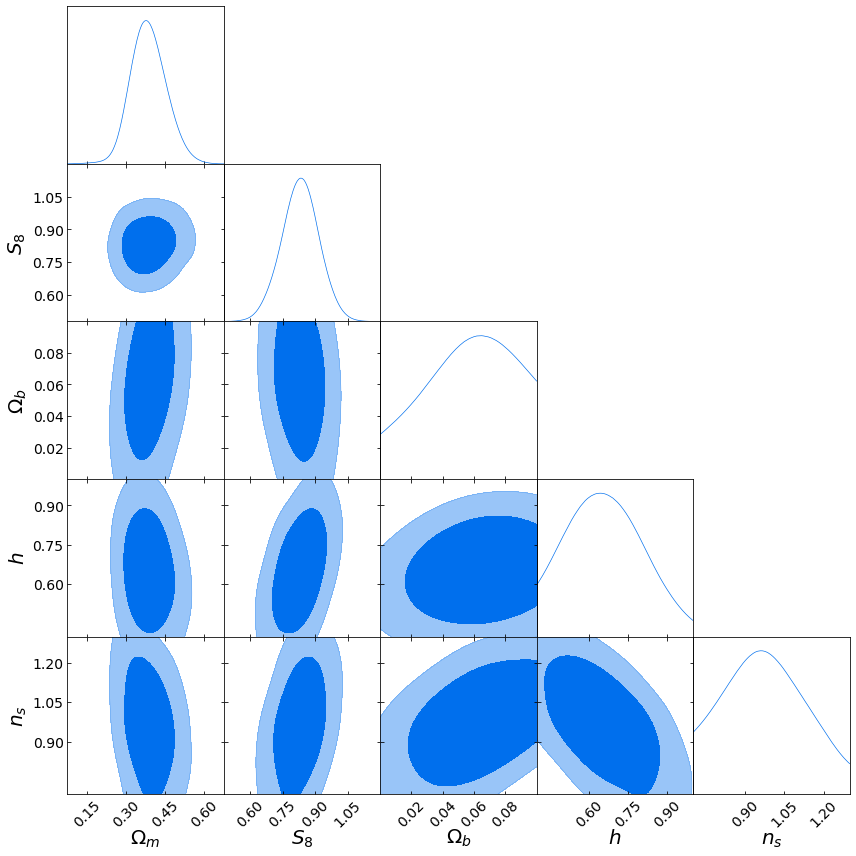

Population 1/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  1%|          | 3/500 [00:01<04:12,  1.97it/s]

Simulator returns exception for parameter values: [0.12907461 0.74881421 0.02685772 0.66149871 1.20268171] (rank 0)
Simulator returns exception for parameter values: [0.12907461 0.74881421 0.02685772 0.66149871 1.20268171] (rank 0)
Simulator returns exception for parameter values: [0.12907461 0.74881421 0.02685772 0.66149871 1.20268171] (rank 0)
Simulator returns exception for parameter values: [0.12907461 0.74881421 0.02685772 0.66149871 1.20268171] (rank 0)


100%|██████████| 500/500 [05:11<00:00,  1.37it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_1.pdf


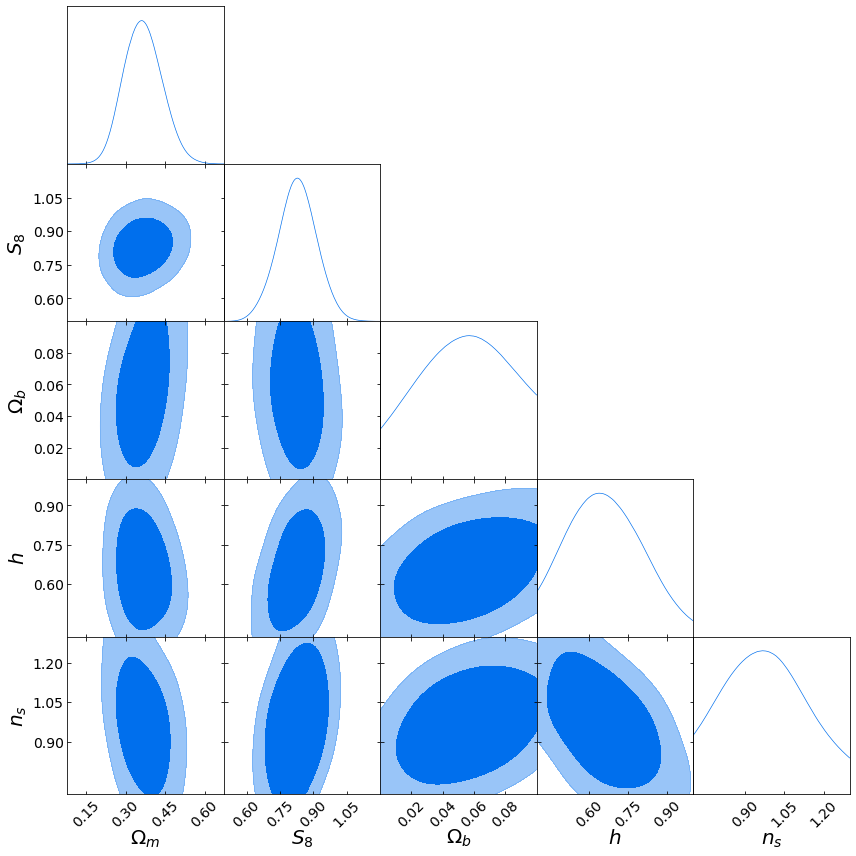

Population 2/15
Sampling proposal density...


  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [05:01<00:00,  1.88it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_2.pdf


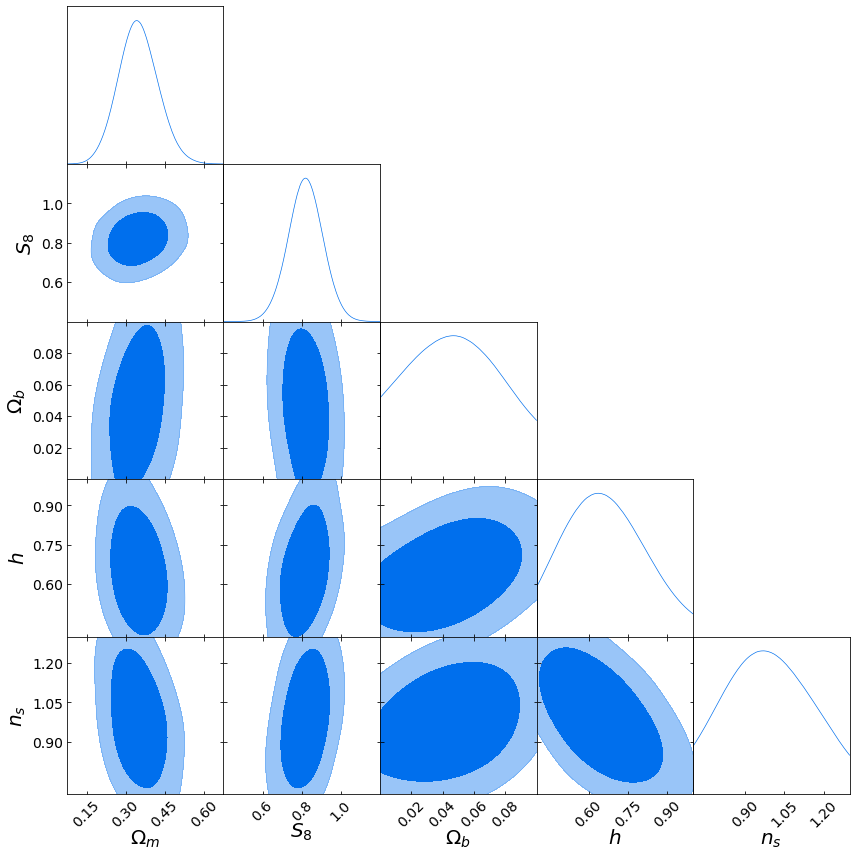

Population 3/15
Sampling proposal density...


  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 24%|██▍       | 122/500 [01:11<03:39,  1.72it/s]

Simulator returns exception for parameter values: [0.16364642 0.76678806 0.04359794 0.51469781 1.23582157] (rank 0)
Simulator returns exception for parameter values: [0.16364642 0.76678806 0.04359794 0.51469781 1.23582157] (rank 0)
Simulator returns exception for parameter values: [0.11768577 0.75419835 0.04108973 0.46433507 1.26314764] (rank 0)
Simulator returns exception for parameter values: [0.10336731 0.74636676 0.0408668  0.44769991 1.27089407] (rank 0)
Simulator returns exception for parameter values: [0.10961471 0.75018544 0.04360737 0.4870536  1.26380325] (rank 0)
Simulator returns exception for parameter values: [0.16336908 0.77126083 0.04388978 0.53161141 1.2217896 ] (rank 0)
Simulator returns exception for parameter values: [0.16336908 0.77126083 0.04388978 0.53161141 1.2217896 ] (rank 0)
Simulator returns exception for parameter values: [0.16336908 0.77126083 0.04388978 0.53161141 1.2217896 ] (rank 0)
Simulator returns exception for parameter values: [0.14610918 0.75491102

100%|██████████| 500/500 [05:06<00:00,  1.81it/s]

Done.



Sampling approximate posterior...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)


Done.
Saving seq_train_post_3.pdf


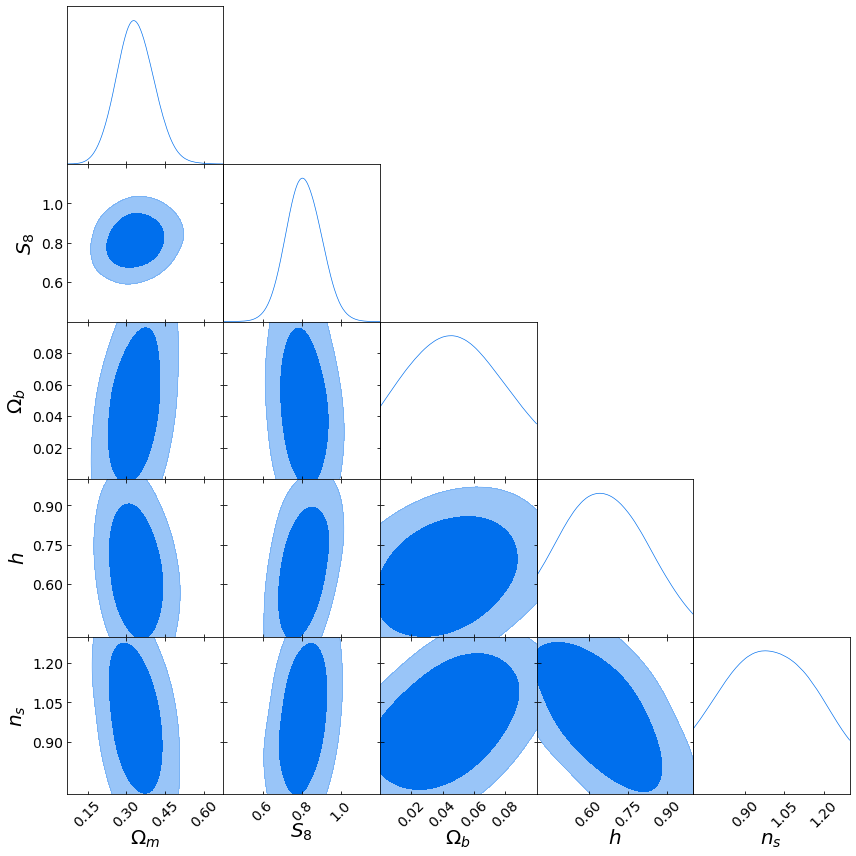

Population 4/15
Sampling proposal density...


  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  8%|▊         | 40/500 [00:36<04:10,  1.84it/s]

Simulator returns exception for parameter values: [0.17801379 0.89796822 0.00610189 0.70388616 1.25184857] (rank 0)
Simulator returns exception for parameter values: [0.17801379 0.89796822 0.00610189 0.70388616 1.25184857] (rank 0)
Simulator returns exception for parameter values: [0.17607683 0.90040305 0.00514565 0.69891853 1.25946925] (rank 0)
Simulator returns exception for parameter values: [0.17607683 0.90040305 0.00514565 0.69891853 1.25946925] (rank 0)
Simulator returns exception for parameter values: [0.17607683 0.90040305 0.00514565 0.69891853 1.25946925] (rank 0)


  8%|▊         | 41/500 [00:37<06:19,  1.21it/s]

Simulator returns exception for parameter values: [0.1595675  0.91126505 0.00376484 0.71261893 1.27114872] (rank 0)
Simulator returns exception for parameter values: [0.1595675  0.91126505 0.00376484 0.71261893 1.27114872] (rank 0)
Simulator returns exception for parameter values: [0.1595675  0.91126505 0.00376484 0.71261893 1.27114872] (rank 0)
Simulator returns exception for parameter values: [0.1595675  0.91126505 0.00376484 0.71261893 1.27114872] (rank 0)
Simulator returns exception for parameter values: [0.1595675  0.91126505 0.00376484 0.71261893 1.27114872] (rank 0)


 18%|█▊        | 89/500 [01:14<03:43,  1.84it/s]

Simulator returns exception for parameter values: [0.16906505 0.87297956 0.01615713 0.79458916 1.15754233] (rank 0)
Simulator returns exception for parameter values: [0.12633047 0.82950845 0.05154681 0.59749811 1.21452674] (rank 0)


 20%|█▉        | 99/500 [01:20<03:32,  1.89it/s]

Simulator returns exception for parameter values: [0.12759343 0.72481206 0.05377175 0.6463608  1.18110811] (rank 0)
Simulator returns exception for parameter values: [0.12759343 0.72481206 0.05377175 0.6463608  1.18110811] (rank 0)
Simulator returns exception for parameter values: [0.09913326 0.7014223  0.05619496 0.6719512  1.17358982] (rank 0)


 20%|██        | 101/500 [01:21<04:13,  1.57it/s]

Simulator returns exception for parameter values: [0.16213855 0.74152918 0.07143371 0.75875029 1.19982983] (rank 0)
Simulator returns exception for parameter values: [0.16213855 0.74152918 0.07143371 0.75875029 1.19982983] (rank 0)
Simulator returns exception for parameter values: [0.16213855 0.74152918 0.07143371 0.75875029 1.19982983] (rank 0)
Simulator returns exception for parameter values: [0.14888204 0.72475992 0.0768611  0.74412532 1.23497345] (rank 0)
Simulator returns exception for parameter values: [0.14568892 0.71988132 0.0784344  0.75016721 1.23422515] (rank 0)
Simulator returns exception for parameter values: [0.14568892 0.71988132 0.0784344  0.75016721 1.23422515] (rank 0)


 39%|███▉      | 195/500 [02:13<02:37,  1.94it/s]

Simulator returns exception for parameter values: [0.16658363 0.91011005 0.00477841 0.60161966 1.28487894] (rank 0)
Simulator returns exception for parameter values: [0.17743894 0.91232097 0.00868917 0.61780393 1.26991282] (rank 0)


 55%|█████▌    | 276/500 [02:57<01:53,  1.98it/s]

Simulator returns exception for parameter values: [0.10763339 0.70709378 0.03747977 0.86182951 1.05167486] (rank 0)


100%|██████████| 500/500 [05:02<00:00,  1.72it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_4.pdf


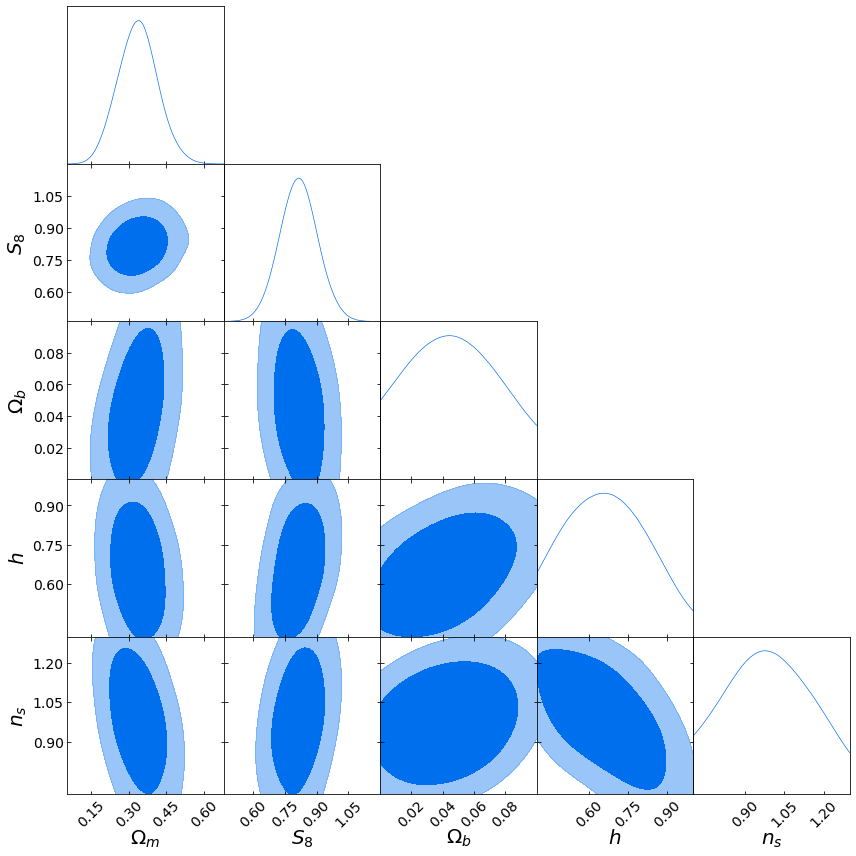

Population 5/15
Sampling proposal density...


  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 82%|████████▏ | 409/500 [04:29<01:09,  1.32it/s]

Simulator returns exception for parameter values: [0.18472031 0.80217824 0.04661063 0.40075745 1.11856072] (rank 0)


 82%|████████▏ | 412/500 [04:31<00:54,  1.60it/s]

Simulator returns exception for parameter values: [0.13074822 0.85784639 0.01375682 0.49226832 1.10025641] (rank 0)
Simulator returns exception for parameter values: [0.09258036 0.84256622 0.00641679 0.46331485 1.09512083] (rank 0)
Simulator returns exception for parameter values: [0.07171401 0.85154265 0.00307323 0.4505559  1.10151753] (rank 0)
Simulator returns exception for parameter values: [0.07171401 0.85154265 0.00307323 0.4505559  1.10151753] (rank 0)


 83%|████████▎ | 415/500 [04:33<00:55,  1.52it/s]

Simulator returns exception for parameter values: [0.15600934 0.87340838 0.01493179 0.57273773 1.09373049] (rank 0)
Simulator returns exception for parameter values: [0.15600934 0.87340838 0.01493179 0.57273773 1.09373049] (rank 0)
Simulator returns exception for parameter values: [0.13662255 0.87586673 0.01394654 0.57660878 1.09083001] (rank 0)
Simulator returns exception for parameter values: [0.13662255 0.87586673 0.01394654 0.57660878 1.09083001] (rank 0)
Simulator returns exception for parameter values: [0.10914754 0.98072026 0.00367349 0.48315513 1.19685295] (rank 0)
Simulator returns exception for parameter values: [0.11702534 0.97547447 0.00502452 0.49073009 1.1836912 ] (rank 0)
Simulator returns exception for parameter values: [0.11702534 0.97547447 0.00502452 0.49073009 1.1836912 ] (rank 0)
Simulator returns exception for parameter values: [0.13535956 0.92607401 0.02197068 0.54702108 1.19617172] (rank 0)


 84%|████████▎ | 418/500 [04:36<01:03,  1.29it/s]

Simulator returns exception for parameter values: [0.18368999 0.87100445 0.0324739  0.60269285 1.03369567] (rank 0)
Simulator returns exception for parameter values: [0.18368999 0.87100445 0.0324739  0.60269285 1.03369567] (rank 0)
Simulator returns exception for parameter values: [0.14754323 0.87281438 0.02709022 0.61394329 0.99661584] (rank 0)
Simulator returns exception for parameter values: [0.14754323 0.87281438 0.02709022 0.61394329 0.99661584] (rank 0)
Simulator returns exception for parameter values: [0.14754323 0.87281438 0.02709022 0.61394329 0.99661584] (rank 0)
Simulator returns exception for parameter values: [0.14754323 0.87281438 0.02709022 0.61394329 0.99661584] (rank 0)


 84%|████████▍ | 419/500 [04:38<01:22,  1.02s/it]

Simulator returns exception for parameter values: [0.18326139 0.89798491 0.02889674 0.67206673 0.98246291] (rank 0)
Simulator returns exception for parameter values: [0.18326139 0.89798491 0.02889674 0.67206673 0.98246291] (rank 0)
Simulator returns exception for parameter values: [0.18326139 0.89798491 0.02889674 0.67206673 0.98246291] (rank 0)


 96%|█████████▋| 482/500 [05:20<00:10,  1.70it/s]

Simulator returns exception for parameter values: [0.17369489 0.86815452 0.05324583 0.70710821 1.00217852] (rank 0)
Simulator returns exception for parameter values: [0.17369489 0.86815452 0.05324583 0.70710821 1.00217852] (rank 0)
Simulator returns exception for parameter values: [0.16579892 0.87771284 0.05637403 0.7194275  1.00146259] (rank 0)


100%|██████████| 500/500 [05:30<00:00,  1.76it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_5.pdf


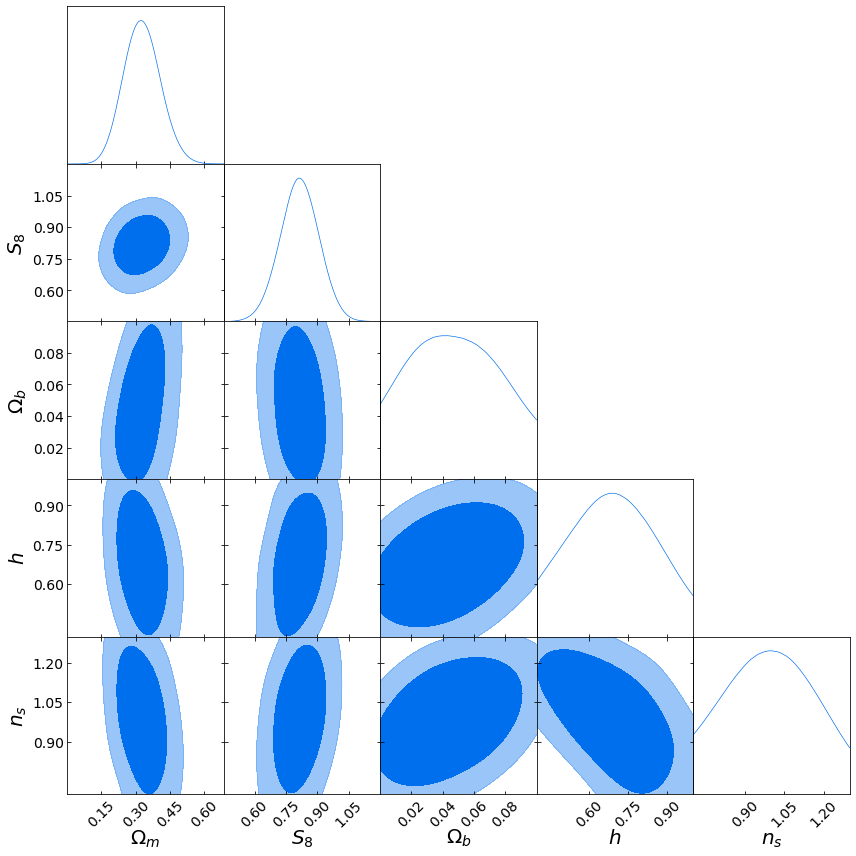

Population 6/15
Sampling proposal density...


  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 17%|█▋        | 83/500 [00:52<03:54,  1.78it/s]

Simulator returns exception for parameter values: [0.17332413 0.94248663 0.02430396 0.85811893 1.20444481] (rank 0)
Simulator returns exception for parameter values: [0.17332413 0.94248663 0.02430396 0.85811893 1.20444481] (rank 0)
Simulator returns exception for parameter values: [0.17332413 0.94248663 0.02430396 0.85811893 1.20444481] (rank 0)
Simulator returns exception for parameter values: [0.16397944 0.94446327 0.02160524 0.88299645 1.19712377] (rank 0)
Simulator returns exception for parameter values: [0.16397944 0.94446327 0.02160524 0.88299645 1.19712377] (rank 0)
Simulator returns exception for parameter values: [0.16397944 0.94446327 0.02160524 0.88299645 1.19712377] (rank 0)
Simulator returns exception for parameter values: [0.16397944 0.94446327 0.02160524 0.88299645 1.19712377] (rank 0)
Simulator returns exception for parameter values: [0.16397944 0.94446327 0.02160524 0.88299645 1.19712377] (rank 0)
Simulator returns exception for parameter values: [0.18586105 0.93797131

100%|██████████| 500/500 [05:28<00:00,  1.68it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_6.pdf


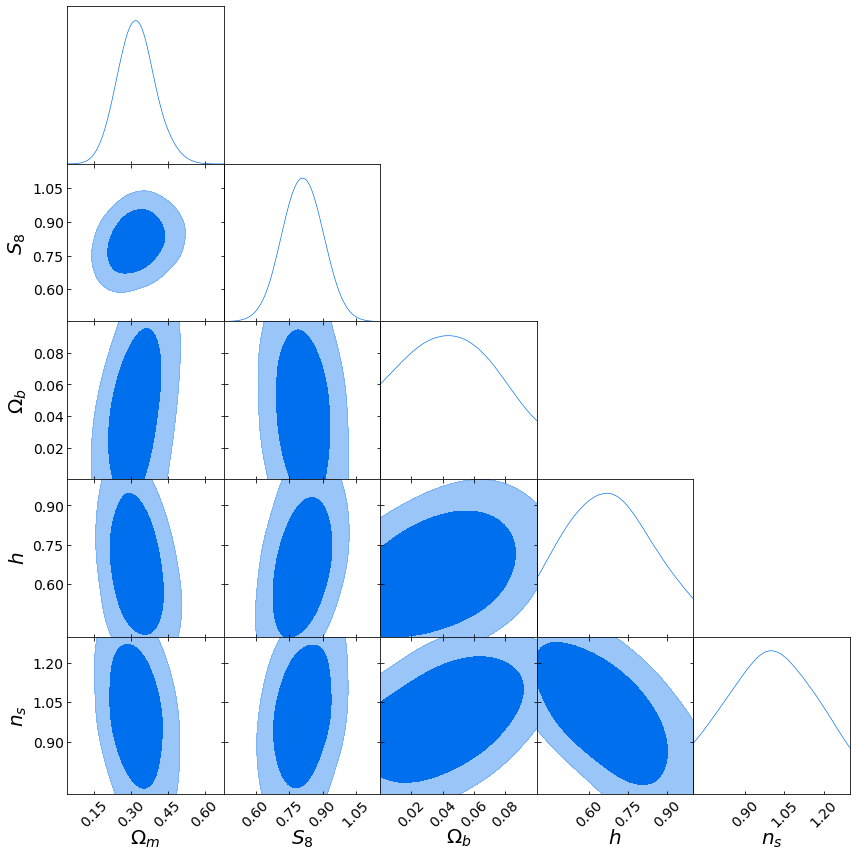

Population 7/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


100%|██████████| 500/500 [05:54<00:00,  1.63it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_7.pdf


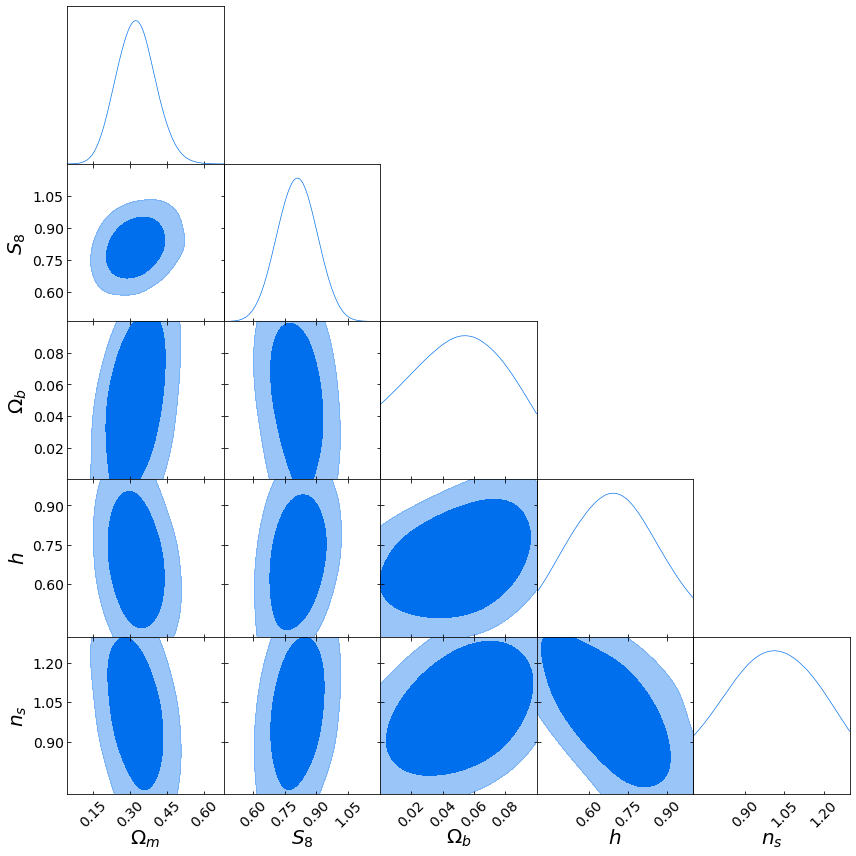

Population 8/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 15%|█▌        | 76/500 [00:52<05:26,  1.30it/s]

Simulator returns exception for parameter values: [0.10058501 0.66227073 0.01043221 0.63561953 1.08612493] (rank 0)
Simulator returns exception for parameter values: [0.10058501 0.66227073 0.01043221 0.63561953 1.08612493] (rank 0)
Simulator returns exception for parameter values: [0.10058501 0.66227073 0.01043221 0.63561953 1.08612493] (rank 0)


 15%|█▌        | 77/500 [00:54<07:18,  1.04s/it]

Simulator returns exception for parameter values: [0.06351253 0.59681808 0.01175614 0.75357862 0.96455526] (rank 0)
Simulator returns exception for parameter values: [0.06351253 0.59681808 0.01175614 0.75357862 0.96455526] (rank 0)
Simulator returns exception for parameter values: [0.06351253 0.59681808 0.01175614 0.75357862 0.96455526] (rank 0)
Simulator returns exception for parameter values: [0.10890058 0.66392034 0.02809569 0.73864877 1.03863153] (rank 0)
Simulator returns exception for parameter values: [0.098931   0.66220778 0.02646846 0.74515808 1.041177  ] (rank 0)


100%|██████████| 500/500 [06:14<00:00,  1.21it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_8.pdf


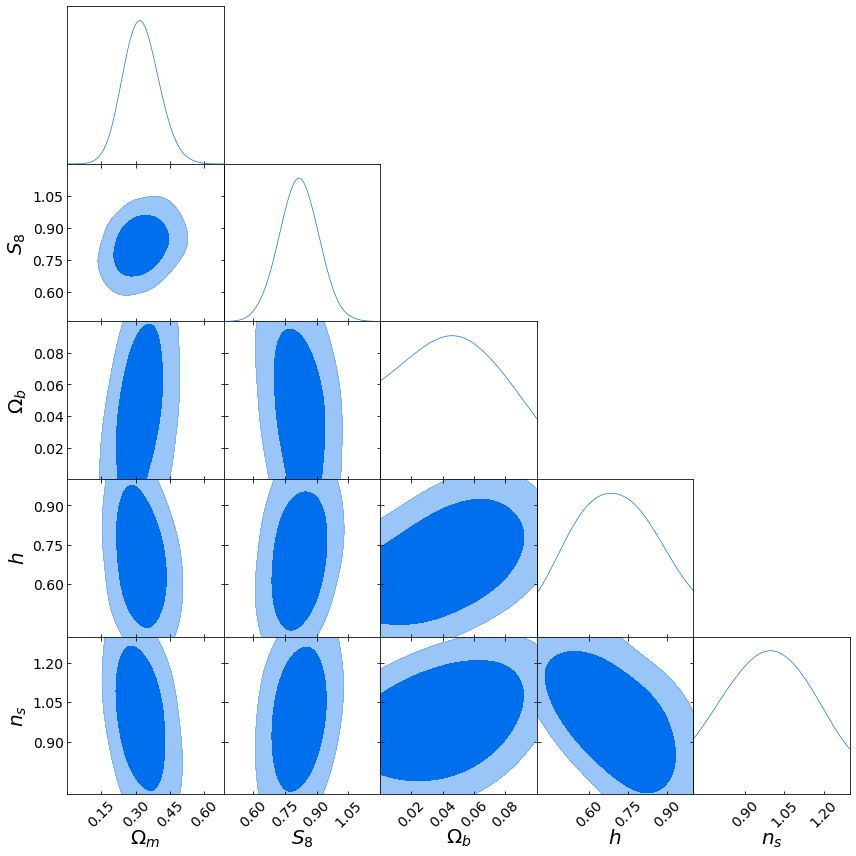

Population 9/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 24%|██▍       | 121/500 [01:23<04:56,  1.28it/s]

Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182 0.00240186 0.98295695 0.98958193] (rank 0)
Simulator returns exception for parameter values: [0.22137406 0.99865182

 28%|██▊       | 139/500 [01:35<03:48,  1.58it/s]

Simulator returns exception for parameter values: [0.14062025 0.94028845 0.0177376  0.91376113 1.29763236] (rank 0)
Simulator returns exception for parameter values: [0.14062025 0.94028845 0.0177376  0.91376113 1.29763236] (rank 0)
Simulator returns exception for parameter values: [0.14062025 0.94028845 0.0177376  0.91376113 1.29763236] (rank 0)
Simulator returns exception for parameter values: [0.14062025 0.94028845 0.0177376  0.91376113 1.29763236] (rank 0)


 28%|██▊       | 142/500 [01:39<05:22,  1.11it/s]

Simulator returns exception for parameter values: [0.15668598 0.90196349 0.01878936 0.83580684 1.24023312] (rank 0)
Simulator returns exception for parameter values: [0.17315486 0.87675082 0.02905815 0.78358334 1.24594746] (rank 0)


 31%|███       | 153/500 [01:49<04:46,  1.21it/s]

Simulator returns exception for parameter values: [0.14121211 0.77870174 0.056704   0.88804875 1.18611489] (rank 0)


 33%|███▎      | 163/500 [01:55<03:15,  1.73it/s]

Simulator returns exception for parameter values: [0.12276913 0.68163456 0.0445187  0.71486202 1.26236007] (rank 0)
Simulator returns exception for parameter values: [0.12276913 0.68163456 0.0445187  0.71486202 1.26236007] (rank 0)


 99%|█████████▉| 494/500 [05:45<00:03,  1.70it/s]

Simulator returns exception for parameter values: [0.1582308  0.83760012 0.02302901 0.81978636 1.01177683] (rank 0)


100%|██████████| 500/500 [05:49<00:00,  1.81it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_9.pdf


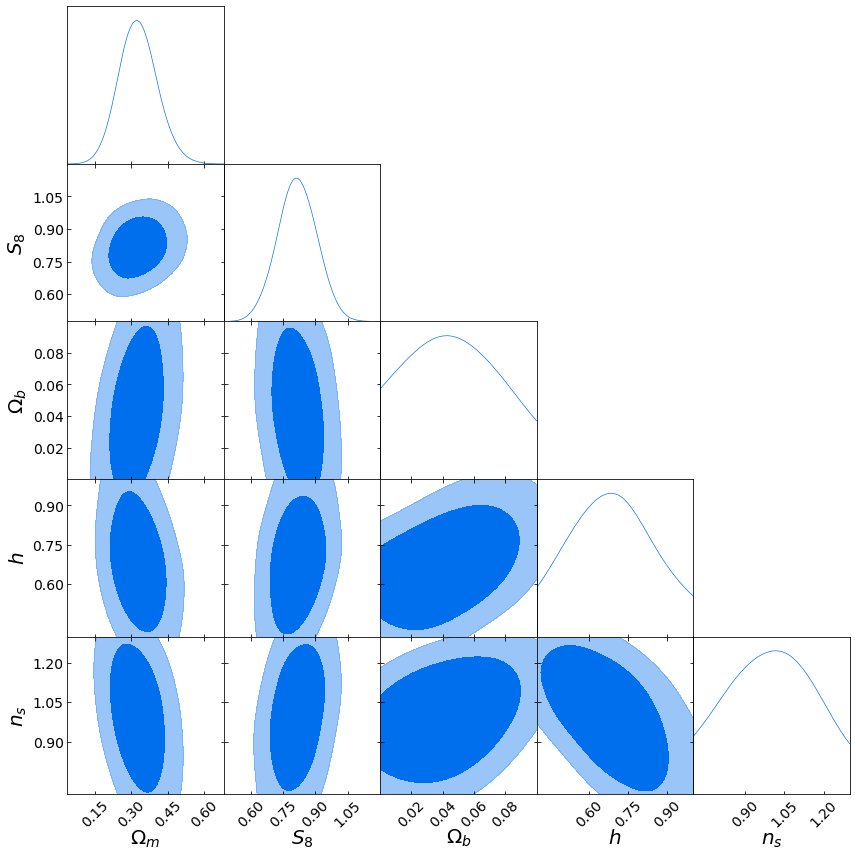

Population 10/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  1%|▏         | 7/500 [00:04<05:46,  1.42it/s]

Simulator returns exception for parameter values: [0.23501309 1.00717581 0.02364942 0.93170263 1.03445369] (rank 0)
Simulator returns exception for parameter values: [0.23501309 1.00717581 0.02364942 0.93170263 1.03445369] (rank 0)
Simulator returns exception for parameter values: [0.23501309 1.00717581 0.02364942 0.93170263 1.03445369] (rank 0)
Simulator returns exception for parameter values: [0.26671761 1.0872086  0.0157954  0.94020938 1.02963   ] (rank 0)


  5%|▌         | 25/500 [00:19<04:43,  1.68it/s]

Simulator returns exception for parameter values: [0.26573052 1.11295661 0.01112138 0.69888931 1.25804507] (rank 0)


 59%|█████▉    | 295/500 [03:49<01:52,  1.82it/s]

Simulator returns exception for parameter values: [0.1377834  0.69419261 0.06209542 0.72806133 1.23526753] (rank 0)
Simulator returns exception for parameter values: [0.1377834  0.69419261 0.06209542 0.72806133 1.23526753] (rank 0)


 70%|███████   | 352/500 [04:28<01:35,  1.55it/s]

Simulator returns exception for parameter values: [0.14304759 0.74197571 0.05498394 0.63556276 1.24995703] (rank 0)
Simulator returns exception for parameter values: [0.14304759 0.74197571 0.05498394 0.63556276 1.24995703] (rank 0)
Simulator returns exception for parameter values: [0.14304759 0.74197571 0.05498394 0.63556276 1.24995703] (rank 0)
Simulator returns exception for parameter values: [0.14304759 0.74197571 0.05498394 0.63556276 1.24995703] (rank 0)
Simulator returns exception for parameter values: [0.13900351 0.74123509 0.05474887 0.63352804 1.25486142] (rank 0)
Simulator returns exception for parameter values: [0.13900351 0.74123509 0.05474887 0.63352804 1.25486142] (rank 0)


 72%|███████▏  | 359/500 [04:33<01:23,  1.68it/s]

Simulator returns exception for parameter values: [0.12429586 0.7207267  0.0551656  0.646354   1.15369872] (rank 0)
Simulator returns exception for parameter values: [0.1414361  0.71591913 0.05492501 0.633085   1.14160463] (rank 0)


 72%|███████▏  | 361/500 [04:34<01:29,  1.55it/s]

Simulator returns exception for parameter values: [0.12986869 0.64627041 0.04272493 0.61551546 1.05989877] (rank 0)
Simulator returns exception for parameter values: [0.12986869 0.64627041 0.04272493 0.61551546 1.05989877] (rank 0)


100%|██████████| 500/500 [06:06<00:00,  1.80it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_10.pdf


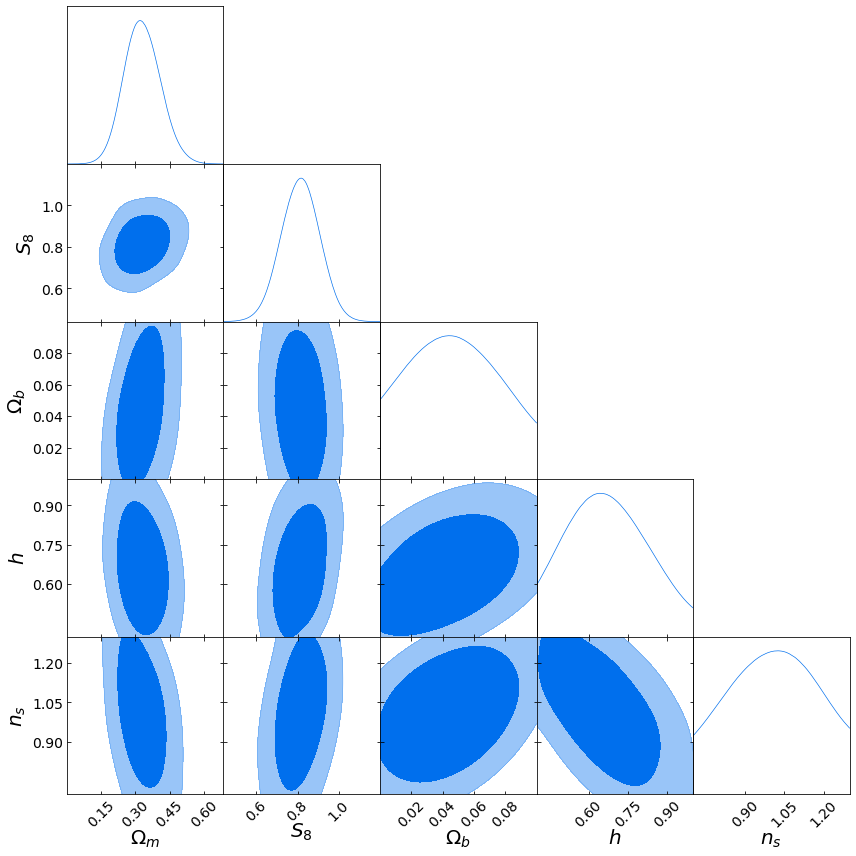

Population 11/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 15%|█▍        | 74/500 [00:46<04:35,  1.54it/s]

Simulator returns exception for parameter values: [0.18431628 0.88287056 0.00331334 0.5544784  0.9077448 ] (rank 0)


100%|██████████| 500/500 [05:25<00:00,  1.81it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_11.pdf


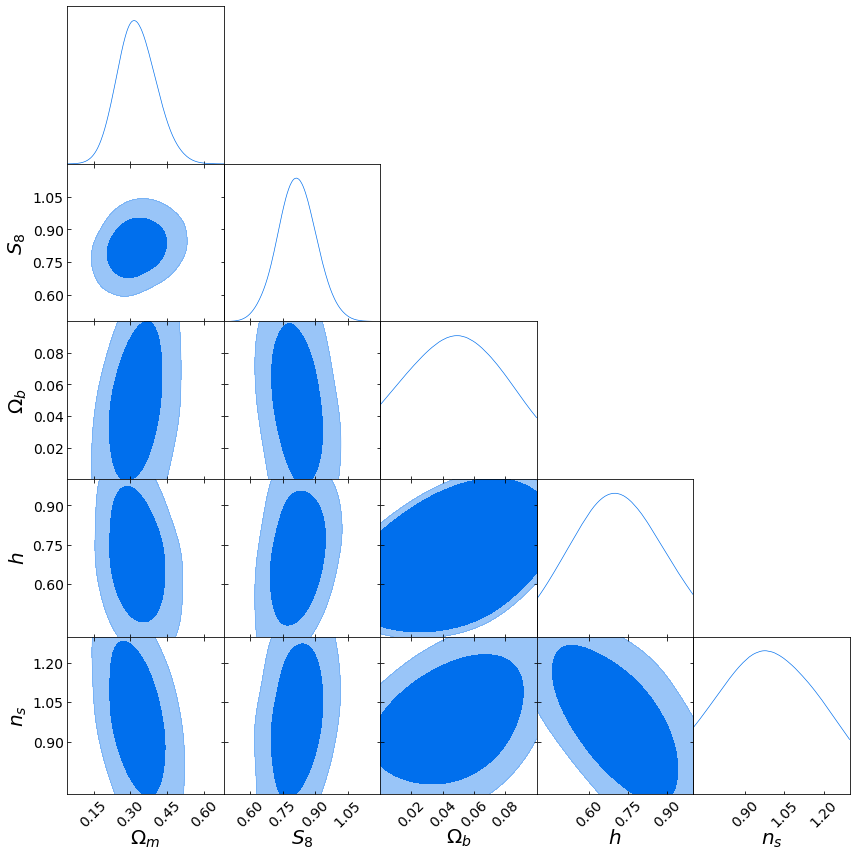

Population 12/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 20%|██        | 101/500 [01:06<04:02,  1.64it/s]

Simulator returns exception for parameter values: [0.18629173 0.89721534 0.0529159  0.86692901 1.2574945 ] (rank 0)


 21%|██        | 106/500 [01:09<03:46,  1.74it/s]

Simulator returns exception for parameter values: [0.09304667 0.78891891 0.03224084 0.97823743 1.08313053] (rank 0)
Simulator returns exception for parameter values: [0.14695119 0.75820255 0.04534454 0.91850225 1.05318573] (rank 0)
Simulator returns exception for parameter values: [0.14695119 0.75820255 0.04534454 0.91850225 1.05318573] (rank 0)


 76%|███████▋  | 382/500 [04:04<01:29,  1.32it/s]

Simulator returns exception for parameter values: [0.15650095 0.81810393 0.01541691 0.84400853 1.0288998 ] (rank 0)
Simulator returns exception for parameter values: [0.15589844 0.81796555 0.01540164 0.84469745 1.02892969] (rank 0)
Simulator returns exception for parameter values: [0.15589844 0.81796555 0.01540164 0.84469745 1.02892969] (rank 0)
Simulator returns exception for parameter values: [0.15589844 0.81796555 0.01540164 0.84469745 1.02892969] (rank 0)
Simulator returns exception for parameter values: [0.15589844 0.81796555 0.01540164 0.84469745 1.02892969] (rank 0)
Simulator returns exception for parameter values: [0.15589844 0.81796555 0.01540164 0.84469745 1.02892969] (rank 0)
Simulator returns exception for parameter values: [0.0779969  0.82535546 0.01016657 0.94624312 1.04850909] (rank 0)
Simulator returns exception for parameter values: [0.1158188  0.79293438 0.0164369  0.87895081 1.01200525] (rank 0)
Simulator returns exception for parameter values: [0.11547375 0.79802744

100%|██████████| 500/500 [05:19<00:00,  1.78it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_12.pdf


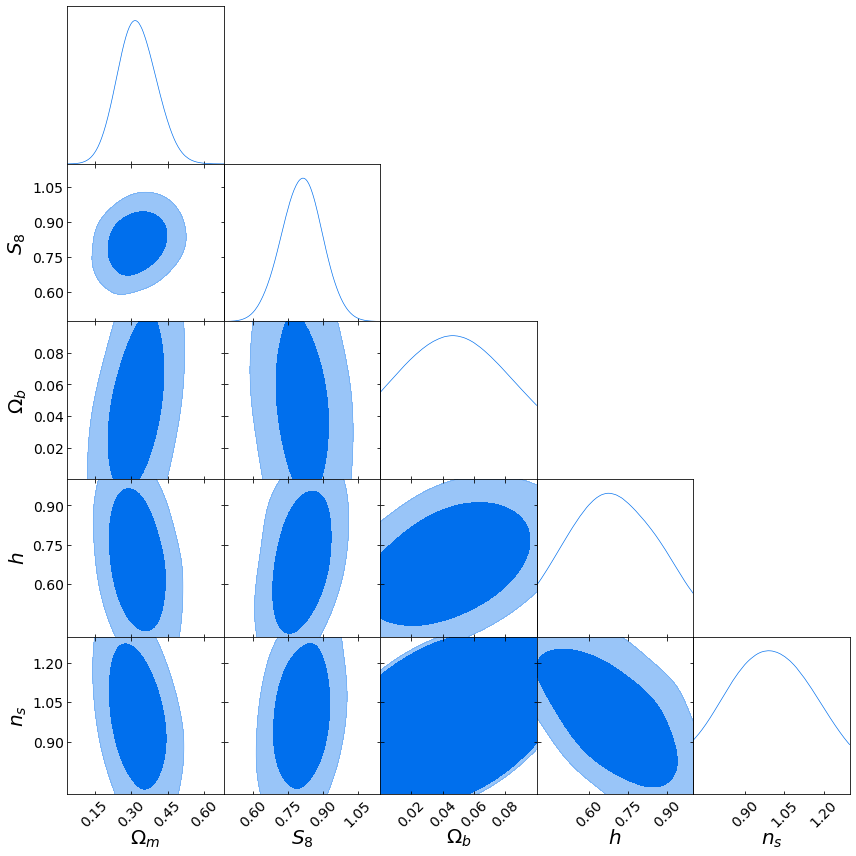

Population 13/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 16%|█▌        | 78/500 [00:46<03:50,  1.83it/s]

Simulator returns exception for parameter values: [0.08036091 0.63660159 0.02157599 0.44204799 1.21920088] (rank 0)


100%|██████████| 500/500 [05:08<00:00,  1.81it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_13.pdf


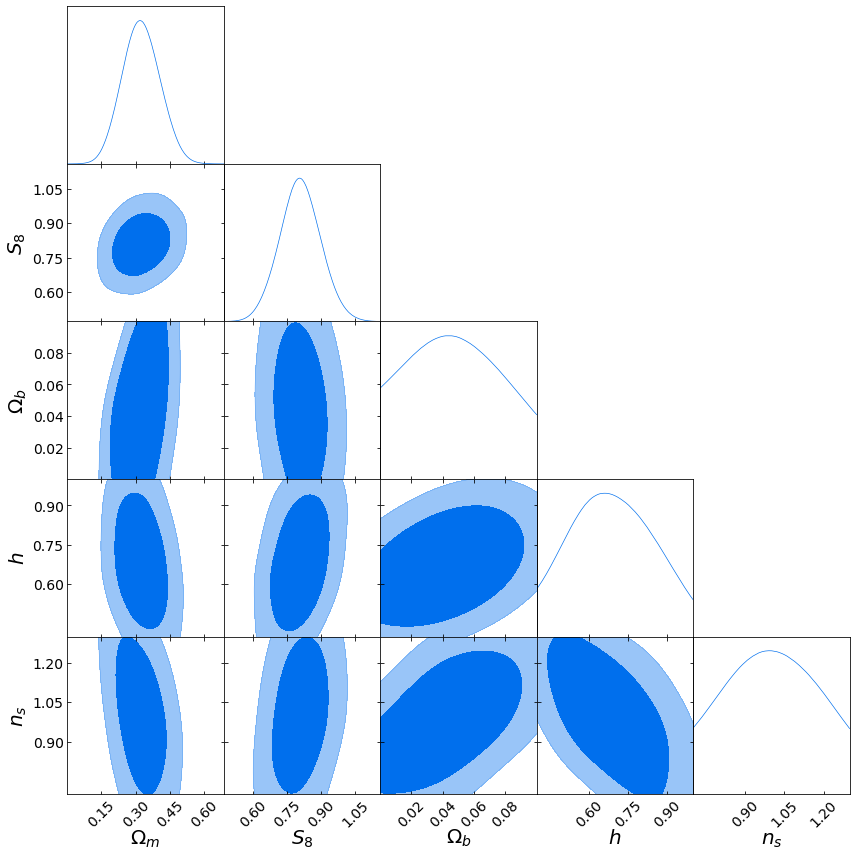

Population 14/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


 69%|██████▉   | 347/500 [03:36<01:22,  1.86it/s]

Simulator returns exception for parameter values: [0.07426299 0.61812875 0.02457379 0.6529108  1.21959193] (rank 0)


 74%|███████▎  | 368/500 [03:47<01:10,  1.86it/s]

Simulator returns exception for parameter values: [0.13088647 0.72054133 0.03879987 0.64306717 1.26594909] (rank 0)
Simulator returns exception for parameter values: [0.13088647 0.72054133 0.03879987 0.64306717 1.26594909] (rank 0)


100%|██████████| 500/500 [05:03<00:00,  1.71it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_14.pdf


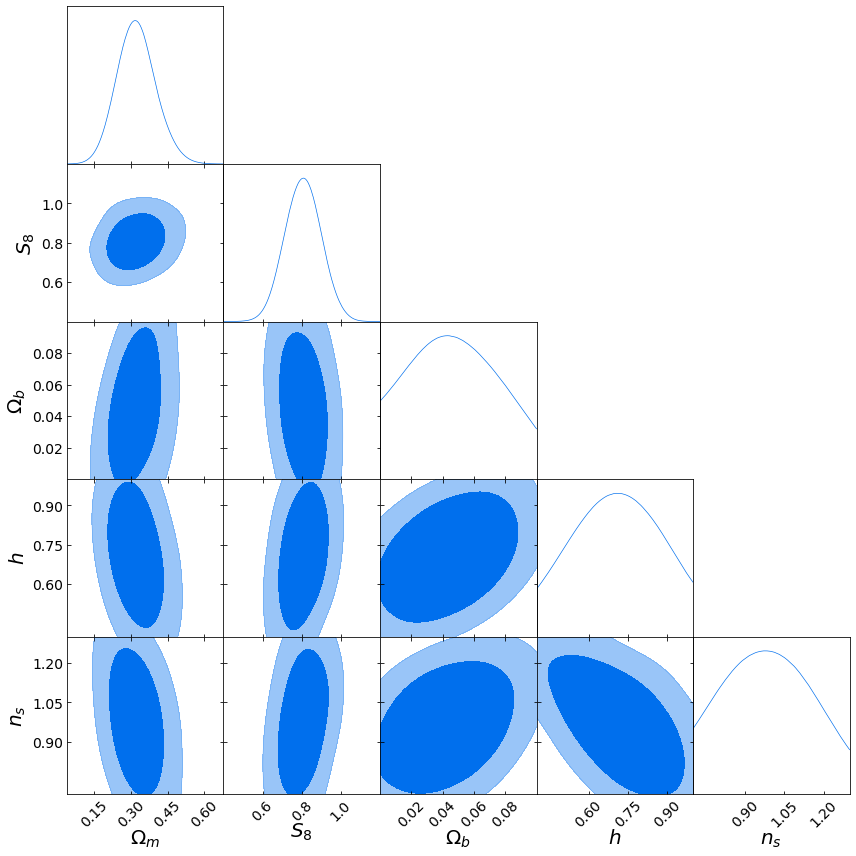

Population 15/15
Sampling proposal density...


/Users/charnock/Physics/delfi/ndes/nde.py:185: RuntimeWarning: divide by zero encountered in log
  if np.isnan(np.log(like)):
/Users/charnock/Physics/delfi/ndes/nde.py:188: RuntimeWarning: divide by zero encountered in log
  return np.log(like)
  0%|          | 0/500 [00:00<?, ?it/s]

Done.
Running 500 sims...


  3%|▎         | 15/500 [00:09<06:14,  1.29it/s]

Simulator returns exception for parameter values: [0.13656319 0.822157   0.01941309 0.79602775 1.17456531] (rank 0)
Simulator returns exception for parameter values: [0.10067045 0.79514561 0.01686022 0.80124129 1.17561999] (rank 0)
Simulator returns exception for parameter values: [0.10067045 0.79514561 0.01686022 0.80124129 1.17561999] (rank 0)
Simulator returns exception for parameter values: [0.10067045 0.79514561 0.01686022 0.80124129 1.17561999] (rank 0)


  7%|▋         | 33/500 [00:23<04:48,  1.62it/s]

Simulator returns exception for parameter values: [0.11981562 0.68125332 0.02543486 0.8425629  1.12746942] (rank 0)
Simulator returns exception for parameter values: [0.07392508 0.66689659 0.01391703 0.83537599 1.18007991] (rank 0)
Simulator returns exception for parameter values: [0.07392508 0.66689659 0.01391703 0.83537599 1.18007991] (rank 0)


  7%|▋         | 34/500 [00:24<05:48,  1.34it/s]

Simulator returns exception for parameter values: [0.13005795 0.69577785 0.01970354 0.79688445 1.08120516] (rank 0)
Simulator returns exception for parameter values: [0.13005795 0.69577785 0.01970354 0.79688445 1.08120516] (rank 0)
Simulator returns exception for parameter values: [0.13005795 0.69577785 0.01970354 0.79688445 1.08120516] (rank 0)
Simulator returns exception for parameter values: [0.13005795 0.69577785 0.01970354 0.79688445 1.08120516] (rank 0)


 10%|█         | 51/500 [00:34<04:04,  1.84it/s]

Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15186238 0.84033792 0.0058804  0.94233689 0.97963154] (rank 0)
Simulator returns exception for parameter values: [0.15152943 0.84500323 0.00419132 0.95323558 0.96634345] (rank 0)
Simulator returns exception for parameter values: [0.13317701 0.84008894 0.002094   0.97257999 0.96094135] (rank 0)
Simulator returns exception for parameter values: [0.13317701 0.84008894

 30%|███       | 152/500 [01:46<04:35,  1.26it/s]

Simulator returns exception for parameter values: [0.23359026 1.06756151 0.03777279 0.79299498 1.2221306 ] (rank 0)
Simulator returns exception for parameter values: [0.23359026 1.06756151 0.03777279 0.79299498 1.2221306 ] (rank 0)
Simulator returns exception for parameter values: [0.23359026 1.06756151 0.03777279 0.79299498 1.2221306 ] (rank 0)
Simulator returns exception for parameter values: [0.23295868 1.01172072 0.04307632 0.78317535 1.20290944] (rank 0)
Simulator returns exception for parameter values: [0.22784229 0.99193531 0.04311084 0.78036126 1.19875646] (rank 0)
Simulator returns exception for parameter values: [0.22784229 0.99193531 0.04311084 0.78036126 1.19875646] (rank 0)
Simulator returns exception for parameter values: [0.22784229 0.99193531 0.04311084 0.78036126 1.19875646] (rank 0)
Simulator returns exception for parameter values: [0.22784229 0.99193531 0.04311084 0.78036126 1.19875646] (rank 0)
Simulator returns exception for parameter values: [0.22784229 0.99193531

 31%|███       | 153/500 [01:48<07:21,  1.27s/it]

Simulator returns exception for parameter values: [0.20744226 1.02666062 0.03737133 0.81740108 1.20786921] (rank 0)
Simulator returns exception for parameter values: [0.20630405 1.03021796 0.03712863 0.81954787 1.21166993] (rank 0)
Simulator returns exception for parameter values: [0.20630405 1.03021796 0.03712863 0.81954787 1.21166993] (rank 0)
Simulator returns exception for parameter values: [0.20630405 1.03021796 0.03712863 0.81954787 1.21166993] (rank 0)
Simulator returns exception for parameter values: [0.20630405 1.03021796 0.03712863 0.81954787 1.21166993] (rank 0)
Simulator returns exception for parameter values: [0.20587322 1.0103667  0.03513104 0.82725706 1.17211555] (rank 0)
Simulator returns exception for parameter values: [0.20587322 1.0103667  0.03513104 0.82725706 1.17211555] (rank 0)


 42%|████▏     | 212/500 [02:26<02:36,  1.85it/s]

Simulator returns exception for parameter values: [0.12512129 0.88223919 0.02104348 0.86812292 1.15612683] (rank 0)
Simulator returns exception for parameter values: [0.09363664 0.89523518 0.01855846 0.9158005  1.21067224] (rank 0)
Simulator returns exception for parameter values: [0.09363664 0.89523518 0.01855846 0.9158005  1.21067224] (rank 0)
Simulator returns exception for parameter values: [0.09363664 0.89523518 0.01855846 0.9158005  1.21067224] (rank 0)


 43%|████▎     | 216/500 [02:29<02:58,  1.59it/s]

Simulator returns exception for parameter values: [0.16020177 0.96454968 0.01311268 0.93482145 1.1157414 ] (rank 0)
Simulator returns exception for parameter values: [0.16020177 0.96454968 0.01311268 0.93482145 1.1157414 ] (rank 0)
Simulator returns exception for parameter values: [0.17058564 0.95387782 0.0165029  0.92582366 1.11526663] (rank 0)
Simulator returns exception for parameter values: [0.17058564 0.95387782 0.0165029  0.92582366 1.11526663] (rank 0)
Simulator returns exception for parameter values: [0.16708201 0.97393126 0.01449764 0.94875245 1.14349648] (rank 0)
Simulator returns exception for parameter values: [0.16708201 0.97393126 0.01449764 0.94875245 1.14349648] (rank 0)
Simulator returns exception for parameter values: [0.16708201 0.97393126 0.01449764 0.94875245 1.14349648] (rank 0)
Simulator returns exception for parameter values: [0.16708201 0.97393126 0.01449764 0.94875245 1.14349648] (rank 0)
Simulator returns exception for parameter values: [0.1862951  0.89820174

 44%|████▍     | 220/500 [02:34<05:03,  1.08s/it]

Simulator returns exception for parameter values: [1.43158130e-01 9.24163602e-01 4.79446004e-04 9.77879232e-01
 1.09688325e+00] (rank 0)


 45%|████▍     | 223/500 [02:38<04:41,  1.01s/it]

Simulator returns exception for parameter values: [0.16566369 0.87975044 0.01343979 0.77979018 1.21378463] (rank 0)
Simulator returns exception for parameter values: [0.16566369 0.87975044 0.01343979 0.77979018 1.21378463] (rank 0)
Simulator returns exception for parameter values: [0.1586533  0.91795545 0.00529835 0.74392901 1.27349371] (rank 0)
Simulator returns exception for parameter values: [0.1586533  0.91795545 0.00529835 0.74392901 1.27349371] (rank 0)
Simulator returns exception for parameter values: [0.1586533  0.91795545 0.00529835 0.74392901 1.27349371] (rank 0)
Simulator returns exception for parameter values: [0.1586533  0.91795545 0.00529835 0.74392901 1.27349371] (rank 0)
Simulator returns exception for parameter values: [0.1586533  0.91795545 0.00529835 0.74392901 1.27349371] (rank 0)
Simulator returns exception for parameter values: [0.17836565 0.90425359 0.01096188 0.72281638 1.26374668] (rank 0)
Simulator returns exception for parameter values: [0.17446582 0.90285008

 62%|██████▏   | 309/500 [03:33<01:48,  1.77it/s]

Simulator returns exception for parameter values: [0.16426558 0.82134076 0.03669454 0.94075028 0.70533363] (rank 0)


 99%|█████████▉| 496/500 [05:26<00:02,  1.84it/s]

Simulator returns exception for parameter values: [0.16854376 0.76433476 0.06685353 0.60047373 1.15231506] (rank 0)


100%|██████████| 500/500 [05:29<00:00,  1.71it/s]

Done.



Sampling approximate posterior...
Done.
Saving seq_train_post_15.pdf


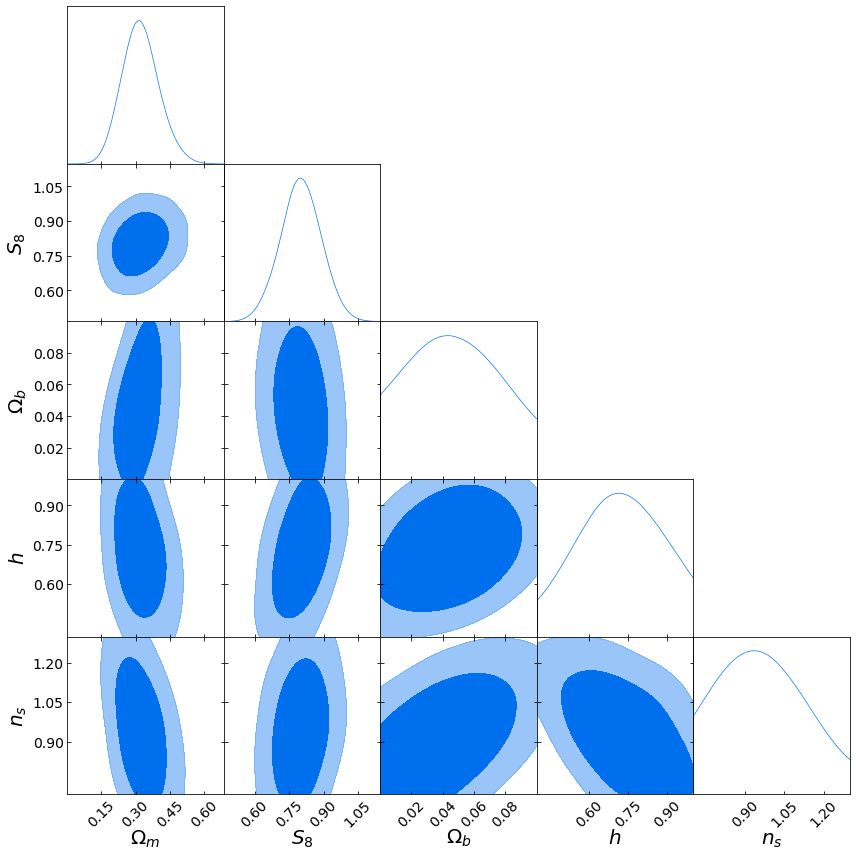

Final round of training with larger SGD batch size...



Done.
Sampling approximate posterior...
Done.
Saving seq_train_post_final.pdf


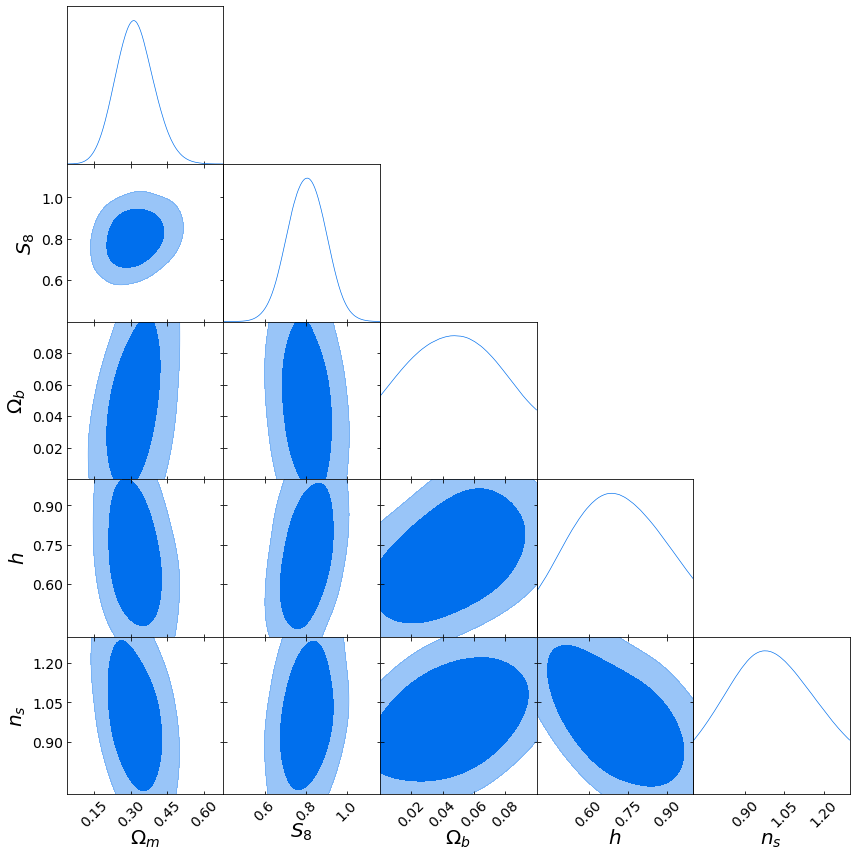

In [11]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*np.linalg.inv(n.sess.run(n.test_F)), lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, proposal, epsilon = 1e-37, simulator_args=simulator_args, compressor_args=compressor_args)

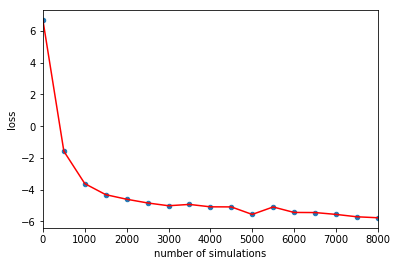

In [12]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()